In [3]:
import pandas as pd
import numpy as np
import talib
import pandas_profiling as pdp
import sweetviz as sv

import os
import sys
from pygam import s, LinearGAM
import category_encoders as ce
from typing import List, Dict

import matplotlib.pyplot as plt
import seaborn as sns

import ptitprince
from matplotlib_venn import venn2
plt.rcParams['font.family'] = 'Hiragino Maru Gothic Pro'

from common_module.utils.plot import (
    plot_venn,
    plot_histogram,
    plot_raincloud,
    plot_heatmap,
    plot_histgram_for_valid,
    plot_lineargam,
    plot_feature_importance_for_valid
)
from common_module.utils.summarize import (
    get_pandas_profiling,
    get_sweetviz_report
)
from common_module.utils.preprocessor import (
    OrdinalEncodingBlock,
    CountEncodingBlock,
    GroupingBlock
)
from common_module.utils.format_df import format_df
from common_module.utils.utils import (
    reduce_mem_usage,
    save_pickle,
    load_pickle
)
from common_module.utils.metrics import (
    calc_MAE,
    calc_MSE,
    calc_RMSE,
    calc_RMSLE
)

from probspace_kiva.modules.config_manager import ConfigManager
# from probspace_kiva.modules.preprocessor import ConcatTrainTestDf
from probspace_kiva.modules.sentence_feature import CleanSentences, CreateSentenceFeatures
from probspace_kiva.modules.validator import (
    make_KFold,
    add_true_for_valid
)
from probspace_kiva.modules.train_module import (
    TrainLGBModule,
    TrainCABModule,
    TrainXGBModule
)
from probspace_kiva.modules.predict import PredictModule
from probspace_kiva.modules.tfidf_svd import TfidfModule
# from probspace_kiva.modules.adversarial_validator import AdversarialValidator


sys.path.append("../")
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saitouteruaki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## config

In [4]:
input_path = "../input/"
output_path = "../output/"

## データ読み込み

In [5]:
df_train_origin = pd.read_csv(os.path.join(input_path, "train.csv"), encoding="utf-8-sig")
df_test_origin = pd.read_csv(os.path.join(input_path, "test.csv"), encoding="utf-8-sig")
df_sample = pd.read_csv(os.path.join(input_path, "sample_submission.csv"), encoding="utf-8-sig")

print(f"df_train_origin: {df_train_origin.shape}")
print(f"df_test_origin: {df_test_origin.shape}")
print(f"df_sample: {df_sample.shape}")

df_train_origin: (91333, 18)
df_test_origin: (91822, 17)
df_sample: (91822, 2)


## Config

In [6]:
# config読み込み
config = ConfigManager(config_path="../config/add_tfidf_setting.yaml")

## tfidf Feature

In [16]:
df_train = df_train_origin.copy()
df_test = df_test_origin.copy()

### TAGS

In [8]:
# train
ins_tfidf_tags = TfidfModule(target="TAGS")
tfidf_vectorizer_tags, svd_tags, df_train_tfidf_tags = ins_tfidf_tags.fit_transform(dataframe=df_train)

# test
df_test_tfidf_tags = ins_tfidf_tags.transform(tfidf_vectorizer=tfidf_vectorizer_tags, svd=svd_tags, dataframe=df_test)

### LOAN_USE

In [9]:
# train
ins_tfidf_loanuse = TfidfModule(target="LOAN_USE")
tfidf_vectorizer_loanuse, svd_loanuse, df_train_tfidf_loanuse = ins_tfidf_loanuse.fit_transform(dataframe=df_train)

# test
df_test_tfidf_loanuse = ins_tfidf_loanuse.transform(tfidf_vectorizer=tfidf_vectorizer_loanuse, svd=svd_loanuse, dataframe=df_test)

In [10]:
df_test_tfidf_tags.head()

,LOAN_ID,TAGS,fixed_TAGS,TFIDF_1_TAGS,TFIDF_2_TAGS
0,2041445,NaN,nan,1.000000,-0.000058
1,1944435,"#Animals, #Repeat Borrower, #Schooling, #Woman...",Animals Repeat Borrower Schooling Woman-Owned ...,0.000041,0.666592
2,2083354,"#Parent, #Single Parent, #Woman-Owned Business",Parent Single Parent Woman-Owned Business,0.000038,0.585813
3,1993565,"#Woman-Owned Business, #Schooling, #Elderly, #...",Woman-Owned Business Schooling Elderly Parent,0.000040,0.623019
4,2064272,NaN,nan,1.000000,-0.000058


## Sentence Feature

In [11]:
df_train = df_train_origin.copy()

ins_clean = CleanSentences(config=config)
df_train_sent = ins_clean.execute(dataframe=df_train)
print("CleanSentences complete")

ins_sent_features = CreateSentenceFeatures(config=config)
df_train_sent = ins_sent_features.execute(dataframe=df_train_sent)
print("CreateSentenceFeatures complete")

CleanSentences complete
CreateSentenceFeatures complete


In [12]:
df_test = df_test_origin.copy()

ins_clean = CleanSentences(config=config)
df_test_sent = ins_clean.execute(dataframe=df_test)
print("CleanSentences complete")

ins_sent_features = CreateSentenceFeatures(config=config)
df_test_sent = ins_sent_features.execute(dataframe=df_test_sent)
print("CreateSentenceFeatures complete")

CleanSentences complete
CreateSentenceFeatures complete


## Merge

In [17]:
# merge
df_train = pd.merge(df_train, df_train_sent, how="left", on="LOAN_ID")
df_train = pd.merge(df_train, df_train_tfidf_tags[["LOAN_ID", "TFIDF_1_TAGS", "TFIDF_2_TAGS"]], how="left", on="LOAN_ID")
df_train = pd.merge(df_train, df_train_tfidf_loanuse[["LOAN_ID", "TFIDF_1_LOAN_USE", "TFIDF_2_LOAN_USE"]], how="left", on="LOAN_ID")
print("train merge complete")


# merge
df_test = pd.merge(df_test, df_test_sent, how="left", on="LOAN_ID")
df_test = pd.merge(df_test, df_test_tfidf_tags[["LOAN_ID", "TFIDF_1_TAGS", "TFIDF_2_TAGS"]], how="left", on="LOAN_ID")
df_test = pd.merge(df_test, df_test_tfidf_loanuse[["LOAN_ID", "TFIDF_1_LOAN_USE", "TFIDF_2_LOAN_USE"]], how="left", on="LOAN_ID")
print("test merge complete")

train merge complete
test merge complete


In [18]:
# config読み込み
config = ConfigManager(config_path="../config/add_tfidf_setting.yaml")

In [19]:
# データ型を修正しメモリを削減する
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

# dtypeのフォーマット修正
df_train = format_df(df_train, dtype_definition=config.feature_columns)
df_test = format_df(df_test, dtype_definition=config.feature_columns)

# 目的変数作成
df_train["LOAN_AMOUNT_log1p"] = np.log1p(df_train["LOAN_AMOUNT"])

Memory usage of dataframe is 41.81 MB
Memory usage after optimization is: 19.40 MB
Decreased by 53.6%
Memory usage of dataframe is 41.33 MB
Memory usage after optimization is: 19.21 MB
Decreased by 53.5%


## BaseLine

### 方針
- 特徴量
    - ORIGINAL_LANGUAGE: category
    - ACTIVITY_NAME: category
    - SECTOR_NAME: category
    - COUNTRY_NAME: category
    - CURRENCY_POLICY: category
    - CURRENCY: category
    - REPAYMENT_INTERVAL: category
- 目的変数
    - LOAN_AMOUNT_log1p: LOAN_AMOUNTを対数変換させたもの。対数取るとおおよそ正規分布になる
- 損失関数
    - RMSE: 評価関数はMAEだけど正解/予測の比率を1に近づければMAEも低くなるのではという発想
- モデル
    - LightGBM
- CV
    - KFold
- 結果
    - 上記だけでは分割できないため、同じ結果になっているLOAN＿IDが複数あった

In [21]:
model_set = {}
importance_set = {}
evals_set = {}
df_val_set = {}
df_test_set = {}
df_val_list = []
df_test_list = []

print(f"train {config.target} ...")
# インスタンス生成
ins_lgb_train = TrainLGBModule(config=config, target=config.target, exec_advasarial_validation=False)
ins_lgb_val_pred = PredictModule(config=config, target=config.target, model_type="lightgbm", is_test=False, clip=False)
ins_lgb_test_pred = PredictModule(config=config, target=config.target, model_type="lightgbm", is_test=True, clip=False)

# kfolds
folds_idx = make_KFold(
    train_x=df_train,
    train_y=df_train[config.target],
    n_splits=config.n_splits,
    random_state=config.random_state
)
# 学習
for cv_num, (tr_idx, va_idx) in enumerate(folds_idx):
    df_train_t, df_train_v = df_train.loc[tr_idx, :], df_train.loc[va_idx, :]
    model_lgb, df_imp_lgb, evals_result_lgb = ins_lgb_train.train_model(train=df_train_t, valid=df_train_v, have_weight=False)
    # dataset への保存
    model_set[f"{config.target}_{cv_num}"] = model_lgb
    importance_set[f"{config.target}_{cv_num}"] = df_imp_lgb
    evals_set[f"{config.target}_{cv_num}"] = evals_result_lgb
    # validationデータを予測
    df_val_pred_lgb = ins_lgb_val_pred.predict(model=model_lgb, test_df=df_train_v, cv_num=cv_num)
    df_val = add_true_for_valid(origin_df=df_train_v, pred_df=df_val_pred_lgb, target=config.target, cv_num=cv_num, config=config)
    use_cols = [f"true_{config.target}", f"pred_{config.target}"]
    df_val[f"true_{config.target}_expm1y"] = np.expm1(df_val[f"true_{config.target}"])
    df_val[f"pred_{config.target}_expm1y"] = np.expm1(df_val[f"pred_{config.target}"])
    mae_score = calc_MAE(
        y_true=df_val[f"true_{config.target}_expm1y"],
        y_pred=df_val[f"pred_{config.target}_expm1y"]
    )
    print(f"■ target_col={config.target} | cv_num={cv_num} | mae_score={mae_score:.4f}")
    df_val_set[f"{config.target}_{cv_num}"] = df_val
    df_val_list.append(df_val)
    # testデータを予測
    df_test_pred_lgb = ins_lgb_test_pred.predict(model=model_lgb, test_df=df_test, cv_num=cv_num)
    df_test_pred_lgb[f"pred_{config.target}_expm1y"] = np.expm1(df_test_pred_lgb[f"pred_{config.target}"])
    df_test_set[f"{config.target}_{cv_num}"] = df_test_pred_lgb
    df_test_list.append(df_test_pred_lgb)
    print("=" * 70)

# validationデータ全体のcvスコア
print("~" * 70)
df_valid_results = pd.concat(df_val_list, ignore_index=True, sort=False)
mae_score_all = calc_MAE(
    y_true=df_valid_results[f"true_{config.target}_expm1y"],
    y_pred=df_valid_results[f"pred_{config.target}_expm1y"]
)
print(f"■ target_col={config.target} | mae_score={mae_score_all:.4f}")

train LOAN_AMOUNT_log1p ...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[390]	train's rmse: 0.381024	valid's rmse: 0.47173
pred LOAN_AMOUNT_log1p ...
■ target_col=LOAN_AMOUNT_log1p | cv_num=0 | mae_score=262.2582
pred LOAN_AMOUNT_log1p ...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[346]	train's rmse: 0.388455	valid's rmse: 0.470013
pred LOAN_AMOUNT_log1p ...
■ target_col=LOAN_AMOUNT_log1p | cv_num=1 | mae_score=263.1477
pred LOAN_AMOUNT_log1p ...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[276]	train's rmse: 0.402295	valid's rmse: 0.471802
pred LOAN_AMOUNT_log1p ...
■ target_col=LOAN_AMOUNT_log1p | cv_num=2 | mae_score=263.5173
pred LOAN_AMOUNT_log1p ...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[319]	train's rmse: 0.394139	valid's rmse: 0.469255
pred LOAN_AMOUNT_log1p ...

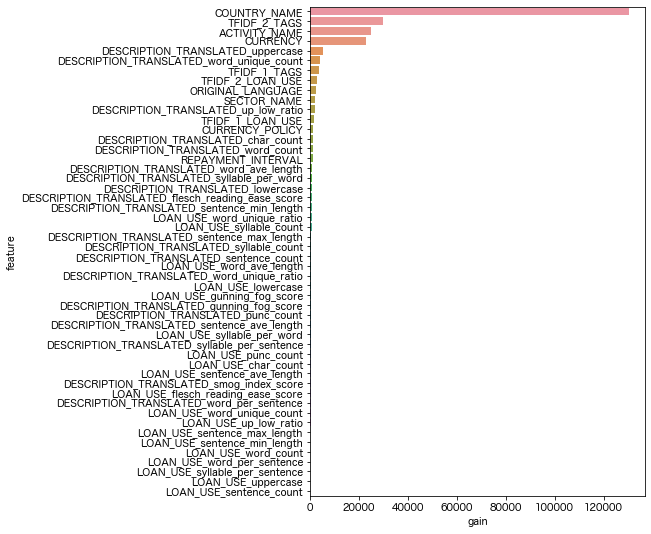

In [22]:
df_imp_ = df_imp_lgb.sort_values("gain", ascending=False)
plt.figure(figsize=(6, 9))
sns.barplot(x=df_imp_["gain"], y=df_imp_["feature"]);

In [23]:
# cv回数分のtest結果の中央値を最終結果とする
df_test_concat = pd.concat(df_test_list, ignore_index=True, sort=False)
df_test_results = df_test_concat.groupby("LOAN_ID", as_index=False)[f"pred_{config.target}_expm1y"].mean()
df_test_results.columns = ["LOAN_ID", "LOAN_AMOUNT"]
df_sample_sub = pd.merge(df_sample.drop("LOAN_AMOUNT", axis=1), df_test_results, how="left", on="LOAN_ID")
df_sample_sub.to_csv(os.path.join(config.output_path, "submission_4.csv"), encoding="utf-8-sig", index=False)

<AxesSubplot:ylabel='Frequency'>

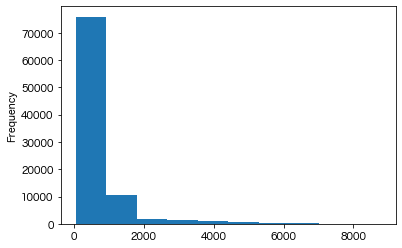

In [24]:
df_sample_sub["LOAN_AMOUNT"].plot(kind="hist")

In [25]:
from torch.utils.data import Dataset
from torchvision.io import read_image

In [26]:
import zipfile

In [62]:
import zipfile

# zipファイルのパス
zip_path = '../input/train_images.zip'

# zipの読み込み
with zipfile.ZipFile(zip_path, 'r') as zip_file:
    # zipファイル内の各ファイルについてループ
    tt = zip_file.infolist()[:10]
    # for info in enumerate(zip_file.infolist()):
    #     # 「zipファイル名/」については処理をしない
    #     if (info.filename != 'data/'):
with zipfile.ZipFile(zip_path, "r") as zip_file:
    # zipファイル内の各ファイルについてループ
    for idx, file_info in enumerate(zip_file.infolist()):
        # 1つ目はzipファイル名のみのためパス
        if idx > 0 and idx < 10:
        # if idx > 0:
            file_name = file_info.filename
            file_id = int(file_name.split("/")[1].split(".")[0])

2833245
2761700
2877141
2872301
2855261
2745631
3305379
3332238
2954750


In [63]:
df = df_train_origin[["LOAN_ID", "IMAGE_ID", "LOAN_AMOUNT"]].copy()
np.log1p(df["LOAN_AMOUNT"]).max()

9.210440366976517

In [55]:
config.input_path

'../input/'

In [40]:
from torchvision.io import read_image
image = read_image(tt[0].filename())

TypeError: 'str' object is not callable